In [2]:
!pip install mclp
!pip install folium pandas
!pip install pulp
!pip install geopy


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import folium
from pulp import LpProblem, LpMaximize, LpMinimize, LpVariable, lpSum, LpBinary
from geopy.distance import geodesic
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from haversine import haversine

In [3]:
bus_df = pd.read_csv("데이터\입지후보데이터\노선_요약.csv")
subway_df = pd.read_csv("데이터\입지후보데이터\지하철_요약.csv")
cafe_df = pd.read_csv("데이터\입지후보데이터\일반음식점(카페)현황.csv", encoding = 'CP949')
park_df = pd.read_csv("데이터\입지후보데이터\도시공원정보현황(제공표준).csv", encoding = 'CP949')

In [ ]:
cafe_df = cafe_df[(cafe_df['시군명'] == '성남시') & (cafe_df['영업상태명'] == '영업')]
cafe_df = cafe_df.rename(columns = {'WGS84위도' : '위도','WGS84경도': '경도'})
# 시설규모 바탕으로 가중치 생성
scaler = MinMaxScaler()
cafe_df['가중치'] = scaler.fit_transform(cafe_df[['총시설규모(㎡)']])
cafe_df

In [ ]:
park_df = park_df[park_df['소재지지번주소'].str.startswith('경기도 성남시')]
park_df['가중치'] = scaler.fit_transform(park_df[['공원면적(㎡)']])
park_df = park_df.dropna(subset=['위도', '경도'])
park_df.isnull().sum()

In [ ]:
bus_df = bus_df.dropna()
bus_df['혼잡도'] = bus_df['환승시간(분)']*bus_df['노선개수']
bus_df['가중치'] = scaler.fit_transform(bus_df[['혼잡도']])
bus_df

In [ ]:
subway_df['일평균승하차인원'] = subway_df['승차총승객수'] + subway_df['하차총승객수']
subway_df['가중치'] = scaler.fit_transform(subway_df[['일평균승하차인원']])
subway_df

In [8]:
# 이름 통일
bus_df = bus_df.rename(columns = {'정류장명':'이름'}) 
subway_df = subway_df.rename(columns = {'역사명':'이름'}) 
cafe_df = cafe_df.rename(columns = {'사업장명':'이름'}) 
park_df = park_df.rename(columns = {'공원명':'이름'}) 

In [ ]:
# 필요한 열만 추출
bus_coords = bus_df[['위도', '경도','가중치','이름']].copy()
subway_coords = subway_df[['위도', '경도','가중치','이름']].copy()
cafe_coords = cafe_df[['위도', '경도','가중치','이름']].copy()
park_coords = park_df[['위도', '경도','가중치','이름']].copy()

# 두 데이터프레임을 위로 붙이기
all_df = pd.concat([bus_coords, subway_coords,cafe_coords,park_coords], ignore_index=True)
all_df

candidate_df = pd.concat([bus_df, park_df], ignore_index=True)

print(candidate_df)

In [40]:
all_df

위도          경도       가중치               이름
0     37.411683  127.099350  0.535547        판교제2테크노밸리
1     37.411333  127.099733  0.396029        판교제2테크노밸리
2     37.422467  127.101233  0.096712           동산마을입구
3     37.422800  127.101400  0.063610           동산마을입구
4     37.428217  127.101650  0.378533  성남농협대왕지점.고등동우체국
...         ...         ...       ...              ...
1598  37.344885  127.118069  0.003110             하얀공원
1599  37.344557  127.114146  0.004754             오리공원
1600  37.337391  127.117303  0.007142             구미공원
1601  37.415308  127.137469  0.001201             연꽃공원
1602  37.414710  127.137412  0.001336             매향공원

[1603 rows x 4 columns]

In [10]:
district_info = {
    '분당구': {'bounds': [[37.300, 127.000], [37.413, 127.170]], '유동인구': 198378136, '폐기물': 57097.45},
    '중원구': {'bounds': [[37.413, 127.120], [37.445, 127.190]], '유동인구': 62310816, '폐기물': 43988.86},
    '수정구1': {'bounds': [[37.413, 127.040], [37.468, 127.120]], '유동인구': 75331308, '폐기물': 63006.79},
    '수정구2': {'bounds': [[37.480, 127.120], [37.445, 127.190]], '유동인구': 75331308, '폐기물': 63006.79},
}

def assign_district_weight(row):
    lat, lon = row['위도'], row['경도']
    for name, info in district_info.items():
        (lat1, lon1), (lat2, lon2) = info['bounds']
        if min(lat1, lat2) <= lat <= max(lat1, lat2) and min(lon1, lon2) <= lon <= max(lon1, lon2):
            return pd.Series({
                '구역': name.replace("1", "").replace("2", ""),
                '구역_유동인구': info['유동인구'],
                '구역_폐기물': info['폐기물']
            })
    return pd.Series({'구역': None, '구역_유동인구': None, '구역_폐기물': None})

# 구역 정보 추가
all_df[['구역', '구역_유동인구', '구역_폐기물']] = all_df.apply(assign_district_weight, axis=1)



In [62]:
print(all_df['가중치'].describe())


count    1603.000000
mean        0.163798
std         0.168257
min         0.000000
25%         0.034396
50%         0.104541
75%         0.232538
max         1.000000
Name: 가중치, dtype: float64


In [11]:
delta = 0.05  # 조정 강도 ±5%

# 1. 유동인구당 폐기물 비율 계산
all_df['유동인구당_폐기물'] = all_df['구역_폐기물'] / all_df['구역_유동인구']

# 2. 구별 영향력 평균값 계산
district_influence = all_df.groupby('구역')['유동인구당_폐기물'].mean().sort_values(ascending=False)

# 3. 순위 기반 보정값 매핑
rank_adjustment = {
    district_influence.index[0]: +delta,
    district_influence.index[1]: 0,
    district_influence.index[2]: -delta,
}

# 4. 각 행에 조정값 적용
all_df['조정비율'] = all_df['구역'].map(rank_adjustment)
all_df['가중치'] = all_df['가중치'] * (1 + all_df['조정비율'])


In [64]:
print(all_df['가중치'].describe())

count    1603.000000
mean        0.161016
std         0.165145
min         0.000000
25%         0.034396
50%         0.106486
75%         0.228888
max         1.050000
Name: 가중치, dtype: float64


In [65]:
# 지도 중심은 첫 번째 버스 정류장
m = folium.Map(location=[bus_df['위도'].iloc[0], bus_df['경도'].iloc[0]], zoom_start=14)

# 버스 정류장 시각화 (파란색)
for _, row in bus_df.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=5,
        popup=row['이름'],
        color='blue',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# 지하철 역사 시각화 (빨간색)
for _, row in subway_df.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=6,
        popup=row['이름'],
        color='red',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# 카페 시각화 (노란색)
for _, row in cafe_df.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=6,
        popup=row['이름'],
        color='yellow',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# 공원 시각화 (초록색)
for _, row in park_df.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=6,
        popup=row['이름'],
        color='green',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# ✅ 바운딩 박스 시각화 (district_info 이용)
for district, info in district_info.items():
    (lat1, lon1), (lat2, lon2) = info['bounds']
    
    # 꼭짓점 네 개 좌표 정의 (시계방향 + 닫기)
    rect = [
        [lat1, lon1],
        [lat1, lon2],
        [lat2, lon2],
        [lat2, lon1],
        [lat1, lon1]
    ]
    
    folium.PolyLine(
        locations=rect,
        color='purple',
        weight=3,
        opacity=0.6,
        popup=f'{district} 경계'
    ).add_to(m)

    # 중심 위치에 마커 추가 (선택사항)
    folium.Marker(
        location=[(lat1 + lat2) / 2, (lon1 + lon2) / 2],
        popup=f'{district}',
        icon=folium.Icon(color='purple', icon='info-sign')
    ).add_to(m)

# 최종 지도 출력
m


In [11]:
# 지도 중심은 첫 번째 버스 정류장
m = folium.Map(location=[bus_df['위도'].iloc[0], bus_df['경도'].iloc[0]], zoom_start=14)

# 버스 정류장 시각화 (파란색)
for _, row in bus_df.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=5,
        popup=row['이름'],
        color='blue',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# 지하철 역사 시각화 (빨간색)
for _, row in subway_df.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=6,
        popup=row['이름'],
        color='red',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# 카페 시각화 (노란색)
for _, row in cafe_df.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=6,
        popup=row['이름'],
        color='yellow',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# 공원 시각화 (초록색)
for _, row in park_df.iterrows():
    folium.CircleMarker(
        location=[row['위도'], row['경도']],
        radius=6,
        popup=row['이름'],
        color='green',
        fill=True,
        fill_opacity=0.7
    ).add_to(m)

# 결과 지도 출력
m

In [72]:
pip install haversine

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
# 위치 좌표 추출
coords = list(zip(all_df['위도'], all_df['경도']))

min_distances = []

# 각 지점에 대해 가장 가까운 다른 지점 거리 계산
for i, origin in enumerate(coords):
    distances = [
        haversine(origin, other, unit='m')
        for j, other in enumerate(coords) if i != j  # 자기 자신 제외
    ]
    min_distance = min(distances)
    min_distances.append(min_distance)

# 평균 최소 거리 계산
average_min_distance = sum(min_distances) / len(min_distances)
print(f"가장 가까운 지점까지의 평균 거리: {average_min_distance:.2f} m")

가장 가까운 지점까지의 평균 거리: 68.80 m


p=5, coverage=0.0382
p=10, coverage=0.0662
p=15, coverage=0.0899
p=20, coverage=0.1117
p=25, coverage=0.1318
p=30, coverage=0.1510
p=35, coverage=0.1695
p=40, coverage=0.1875
p=45, coverage=0.2047
p=50, coverage=0.2210
p=55, coverage=0.2366
p=60, coverage=0.2512
p=65, coverage=0.2653
p=70, coverage=0.2791
p=75, coverage=0.2925
p=80, coverage=0.3056
p=85, coverage=0.3182
p=90, coverage=0.3307
p=95, coverage=0.3428
p=100, coverage=0.3546
p=105, coverage=0.3661
p=110, coverage=0.3773
p=115, coverage=0.3883
p=120, coverage=0.3990
p=125, coverage=0.4095
p=130, coverage=0.4198
p=135, coverage=0.4299
p=140, coverage=0.4398
p=145, coverage=0.4497
p=150, coverage=0.4594
p=155, coverage=0.4690
p=160, coverage=0.4784
p=165, coverage=0.4877
p=170, coverage=0.4969
p=175, coverage=0.5060
p=180, coverage=0.5149
p=185, coverage=0.5237
p=190, coverage=0.5325
p=195, coverage=0.5410
p=200, coverage=0.5494
p=205, coverage=0.5578
p=210, coverage=0.5659
p=215, coverage=0.5738
p=220, coverage=0.5815
p=225, c

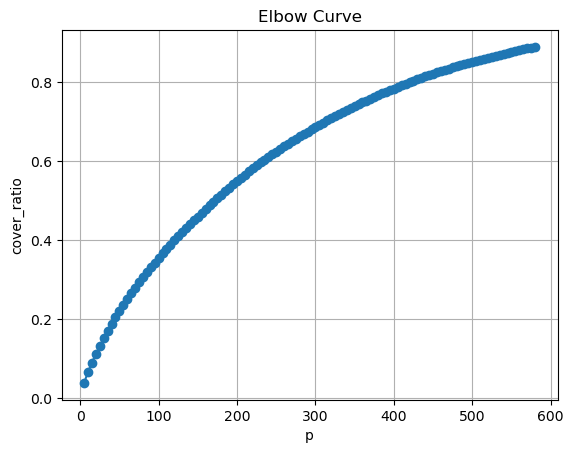

In [78]:
coverage_radius = 68.8  
p_step = 5
p_max = min(len(candidate_bins), 1000)  # 너무 크면 제한
early_stop_delta = 0.002  # 증가폭이 너무 작으면 종료

# 거리 행렬 (빠른 계산 전제)
distance_matrix = [
    [haversine(dp[:2], cb[:2], unit='m') for cb in candidate_bins]
    for dp in demand_points
]

coverage_ratios = []
p_values = []

previous_ratio = 0
total_weight = sum(dp[2] for dp in demand_points)

for p in range(5, p_max + 1, p_step):
    # 변수 정의
    x = [LpVariable(f"x_{j}", cat=LpBinary) for j in range(len(candidate_bins))]
    y = [LpVariable(f"y_{i}", cat=LpBinary) for i in range(len(demand_points))]

    # 모델
    model = LpProblem("MCLP", LpMaximize)
    model += lpSum([demand_points[i][2] * y[i] for i in range(len(demand_points))])

    # 제약조건
    for i in range(len(demand_points)):
        model += lpSum([x[j] for j in range(len(candidate_bins)) if distance_matrix[i][j] <= coverage_radius]) >= y[i]
    model += lpSum(x) <= p

    # 최적화
    model.solve()

    # 결과 계산
    covered_weight = sum(demand_points[i][2] for i in range(len(demand_points)) if y[i].varValue == 1)
    ratio = covered_weight / total_weight
    coverage_ratios.append(ratio)
    p_values.append(p)

    print(f"p={p}, coverage={ratio:.4f}")

    # 증가폭이 작으면 멈춤
    if ratio - previous_ratio < early_stop_delta:
        break
    previous_ratio = ratio

# 그래프 출력
plt.plot(p_values, coverage_ratios, marker='o')
plt.title("Elbow Curve")
plt.xlabel("p")
plt.ylabel("cover_ratio")
plt.grid(True)
plt.show()

In [80]:
# 수요지점과 후보지점 
demand_points = list(zip(all_df['위도'], all_df['경도'], all_df['가중치'], all_df['이름']))  # 카페, 공원, 버스정류장, 지하철 위치 및 가중치

candidate_bins = list(zip(candidate_df['위도'], candidate_df['경도'], candidate_df['이름']))  # 후보지는 공원이랑 버스정류장

# # 거리 행렬
# distance_matrix = [
#     [geodesic(dp[:2], cb[:2]).meters for cb in candidate_bins]
#     for dp in demand_points
# ]

# 거리 행렬 (빠른 계산 전제)
distance_matrix = [
    [haversine(dp[:2], cb[:2], unit='m') for cb in candidate_bins]
    for dp in demand_points
]

# 파라미터 설정
coverage_radius = 68.8  # meters
p = 580  # 쓰레기통 설치 개수 제한

# 이진 변수
x = [LpVariable(f"x_{j}", cat=LpBinary) for j in range(len(candidate_bins))]  # 후보지 설치 여부
y = [LpVariable(f"y_{i}", cat=LpBinary) for i in range(len(demand_points))]  # 수요지 커버 여부

# 모델 생성
model = LpProblem("MCLP_Weighted", LpMaximize)

# 목적 함수: 커버된 수요의 가중치 총합 최대화
model += lpSum([demand_points[i][2] * y[i] for i in range(len(demand_points))])

# 제약 1: 반경 내 후보지점이 있어야 커버 인정
for i in range(len(demand_points)):
    model += lpSum([x[j] for j in range(len(candidate_bins)) if distance_matrix[i][j] <= coverage_radius]) >= y[i]

# 제약 2: 설치 개수 제한
model += lpSum(x) <= p

# 최적화 수행
model.solve()


1

In [81]:
import folium

# 지도 중심을 전체 수요지점 평균으로
center_lat = sum([dp[0] for dp in demand_points]) / len(demand_points)
center_lon = sum([dp[1] for dp in demand_points]) / len(demand_points)

# 지도 초기화
m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

# 수요지점 시각화
for i, (lat, lon, weight, name) in enumerate(demand_points):
    covered = y[i].varValue > 0.5
    folium.CircleMarker(
        location=[lat, lon],
        radius=4 + weight * 10,  # 가중치 기반 크기
        color='black' if covered else 'lightgray',  # 커버 여부에 따라 테두리
        fill=True,
        fill_color='orange' if covered else 'white',
        fill_opacity=0.8,
        tooltip=name,
        popup=f"가중치: {round(weight, 3)}"
    ).add_to(m)

# 설치된 쓰레기통 위치 마커
for j, (lat, lon, name) in enumerate(candidate_bins):
    if x[j].varValue > 0.5:
        folium.Marker(
            location=[lat, lon],
            icon=folium.Icon(color='red', icon='trash', prefix='fa'),
            tooltip=name,
            popup=f"설치 위치: {name}"
        ).add_to(m)

# 지도 출력
m


In [82]:
# 쓰레기통 설치 결과를 DataFrame으로 저장
result_df = pd.DataFrame(candidate_bins, columns=['위도', '경도', '이름'])
result_df['설치여부'] = [int(var.varValue) for var in x]

# 설치된 위치만 필터링
installed_bins = result_df[result_df['설치여부'] == 1]

# CSV로 저장
installed_bins.to_csv("mclp_installed_bins.csv", index=False, encoding = "CP949")